In [1]:
import requests
import urllib3
from urllib3.exceptions import InsecureRequestWarning
urllib3.disable_warnings(InsecureRequestWarning)

# 書類一覧から書類管理番号を取得する関数
def get_doc_id(date, edinet_code, doc_type):

    # EDINETのAPIを使って書類一覧を取得する
    url = 'https://disclosure.edinet-fsa.go.jp/api/v1/documents.json'
    params = {
    "date": date,
    "type": 2,
    }
    
    docs = requests.get(url, params=params, verify=False)
    docs_results = docs.json()['results']
    
    for result in docs_results:
        if result['docTypeCode'] != doc_type: # 書類種別コードで抽出
            continue
        if result['edinetCode'] == edinet_code: # EDINETコードで抽出
            doc_id = result['docID'] # 書類管理番号を取得
    
    return doc_id

# 日付、EDINETコード、書類種別コードを指定して書類管理番号を取得する
date = '2022-06-30'
edinet_code = 'E02367' # 「任天堂」
doc_type = '120' # 「有価証券報告書」

doc_id = get_doc_id(date, edinet_code, doc_type)

print(doc_id)

S100O9PP


In [2]:
from pathlib import Path
import zipfile
import os

# 指定した書類管理番号の書類を取得し、zip形式で保存
def download_zip(date, edinet_code, doc_id):

    # EDINETのAPIを使って書類をダウンロードする
    url = f'https://disclosure.edinet-fsa.go.jp/api/v1/documents/{doc_id}'
    params = {
    "type": 1
    }

    binary_response = requests.get(url, params=params, verify=False)
    
    # 有価証券報告書を保存する「yuho_report」フォルダーを作る
    file_path = Path(r'C:/Users/nobuaki/finance.ipynb')
    base_dir = os.path.abspath(os.path.dirname(file_path))
    save_dir_name = 'yuho_report'
    if not os.path.exists(Path(base_dir, save_dir_name)):
        os.makedirs(Path(base_dir, save_dir_name))
    
    # 書類のファイル名を「日付_EDINETコード」に設定する
    file_path = f'{base_dir}/{save_dir_name}/{date}_{edinet_code}'
    # 書類をzip形式で保存する
    with open(f'{file_path}.zip', 'wb') as f:
        for chunk in binary_response.iter_content(chunk_size=1024):
            f.write(chunk)
    
    # zipファイルを解凍する
    with zipfile.ZipFile(f'{file_path}.zip') as existing_zip:
        existing_zip.extractall(file_path)
    
    return file_path

# 日付、EDINETコード、書類種別コードを指定して書類管理番号を取得する
date = '2022-06-30'
edinet_code = 'E02367' # 「任天堂」
doc_type = '120' # 「有価証券報告書」

doc_id = get_doc_id(date, edinet_code, doc_type)
file_path = download_zip(date, edinet_code, doc_id)

print(file_path)

C:\Users\nobuaki/yuho_report/2022-06-30_E02367


In [3]:
from arelle import Cntlr, ModelManager
from arelle.ModelValue import qname
import time

# Arelleを使って売上高を抽出するコード
ctrl = Cntlr.Cntlr()
model_manager = ModelManager.initialize(ctrl)
xbrl_file_path = f'{file_path}/XBRL/PublicDoc/jpcrp030000-asr-001_E02367-000_2022-03-31_01_2022-06-30.xbrl'

model_xbrl = model_manager.load(xbrl_file_path)

ns = model_xbrl.prefixedNamespaces["jppfs_cor"]
qn = qname(ns,name="jppfs_cor_NetSales")
facts = model_xbrl.factsByQname[qn]

for fact in model_xbrl.facts:
    jp_label = fact.concept.label()
    if jp_label == "売上高" and fact.concept.qname.localName == "NetSalesSummaryOfBusinessResults" and (not "NonConsolidatedMember" in fact.contextID):
        print(fact)

model_manager.close()



modelFact[89041, qname: jpcrp_cor:NetSalesSummaryOfBusinessResults, contextRef: Prior4YearDuration, unitRef: JPY, value: 1,055,682,000,000, jpcrp030000-asr-001_E02367-000_2022-03-31_01_2022-06-30.xbrl, line 2290]
modelFact[89042, qname: jpcrp_cor:NetSalesSummaryOfBusinessResults, contextRef: Prior3YearDuration, unitRef: JPY, value: 1,200,560,000,000, jpcrp030000-asr-001_E02367-000_2022-03-31_01_2022-06-30.xbrl, line 2291]
modelFact[89043, qname: jpcrp_cor:NetSalesSummaryOfBusinessResults, contextRef: Prior2YearDuration, unitRef: JPY, value: 1,308,519,000,000, jpcrp030000-asr-001_E02367-000_2022-03-31_01_2022-06-30.xbrl, line 2292]
modelFact[89044, qname: jpcrp_cor:NetSalesSummaryOfBusinessResults, contextRef: Prior1YearDuration, unitRef: JPY, value: 1,758,910,000,000, jpcrp030000-asr-001_E02367-000_2022-03-31_01_2022-06-30.xbrl, line 2293]
modelFact[89045, qname: jpcrp_cor:NetSalesSummaryOfBusinessResults, contextRef: CurrentYearDuration, unitRef: JPY, value: 1,695,344,000,000, jpcrp03

売上高：[1055682000000, 1200560000000, 1308519000000, 1758910000000, 1695344000000]
経常利益：[199356000000, 277355000000, 360461000000, 678996000000, 670813000000]
自己資本利益率（ROE）：[0.1086, 0.1422, 0.1753, 0.2813, 0.2423]
株価収益率（PER）：[40.32, 19.54, 19.16, 15.33, 15.24]


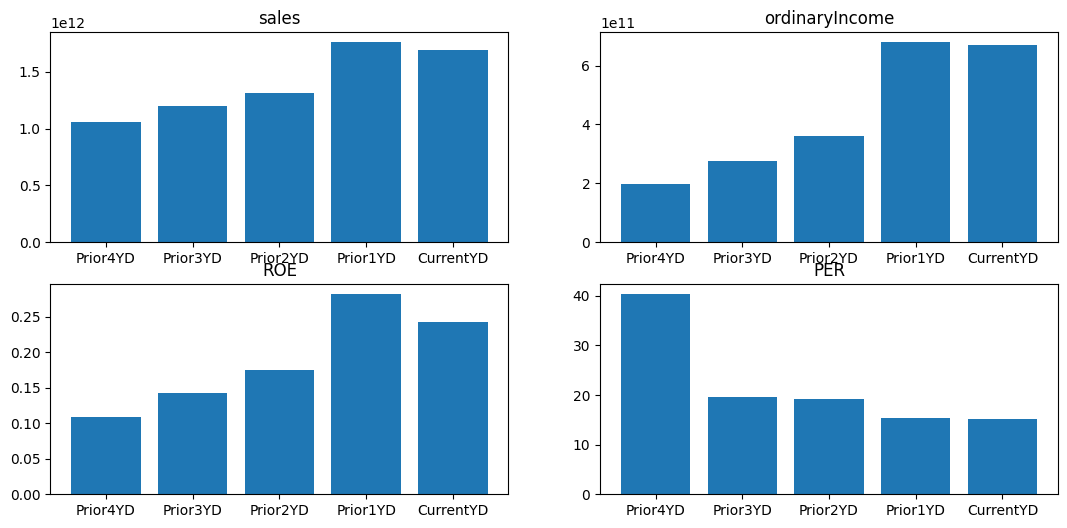

In [4]:
from arelle import Cntlr, ModelManager
from arelle.ModelValue import qname
import time
import matplotlib.pyplot as plt

# Arelleを使って売上高を抽出するコード
ctrl = Cntlr.Cntlr()
model_manager = ModelManager.initialize(ctrl)
xbrl_file_path = f'{file_path}/XBRL/PublicDoc/jpcrp030000-asr-001_E02367-000_2022-03-31_01_2022-06-30.xbrl'

model_xbrl = model_manager.load(xbrl_file_path)

ns = model_xbrl.prefixedNamespaces["jppfs_cor"]
qn = qname(ns,name="jppfs_cor_NetSales")
facts = model_xbrl.factsByQname[qn]

sales_list=[]
ordinaryIncome_list=[]
roe_list=[]
per_list=[]

tag_label_list = ["Prior4YearDuration","Prior3YearDuration", "Prior2YearDuration","Prior1YearDuration", "CurrentYearDuration"]
label_list = ["Prior4YD","Prior3YD","Prior2YD","Prior1YD", "CurrentYD"]

for fact in model_xbrl.facts:
    jp_label = fact.concept.label()
    if jp_label == "売上高" and fact.concept.qname.localName == "NetSalesSummaryOfBusinessResults" and (fact.contextID in tag_label_list):
        sales_list.append(int(fact.value))

    elif jp_label == "経常利益又は経常損失（△）" and (not "NonConsolidatedMember" in fact.contextID) and (fact.contextID in tag_label_list):
        if not int(fact.value) in ordinaryIncome_list:
            ordinaryIncome_list.append(int(fact.value))

    elif jp_label == "自己資本利益率" and (not "NonConsolidatedMember" in fact.contextID) and (fact.contextID in tag_label_list):
        roe_list.append(float(fact.value))

    elif jp_label == "株価収益率" and (not "NonConsolidatedMember" in fact.contextID)and (fact.contextID in tag_label_list):
        per_list.append(float(fact.value))

print('売上高：{0}'.format(sales_list))
print('経常利益：{0}'.format(ordinaryIncome_list))
print('自己資本利益率（ROE）：{0}'.format(roe_list))
print('株価収益率（PER）：{0}'.format(per_list))

fig = plt.figure(figsize=(13,6))

sales = fig.add_subplot(2, 2, 1)
sales.bar(label_list, sales_list)
sales.set_title("sales")

ordinaryIncome = fig.add_subplot(2, 2, 2)
ordinaryIncome.bar(label_list, ordinaryIncome_list)
ordinaryIncome.set_title("ordinaryIncome")

roe = fig.add_subplot(2, 2, 3)
roe.bar(label_list, roe_list)
roe.set_title("ROE")

per = fig.add_subplot(2, 2, 4)
per.bar(label_list, per_list)
per.set_title("PER")

plt.show()

model_manager.close()
